In [4]:
!pip install plotly

In [5]:
# https://www.kaggle.com/code/dimitriosthomaidis/xgboost-feature-engineering/notebook
# https://www.kaggle.com/code/subhranilmondal12/data-visualization-mlmodel-withcross-validation/notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid', {'grid.color' : '.6', 'grid.linestyle' : ':'})


DF = pd.read_csv('../credit_customers.csv')

### Dataset Description

- checking_status; status of existing checking account
- duration; duration in months
- credit_history; credits take, paid back duly, delays, critical accounts
- purpose; purpose of the credit
- credit_amount; amount of credit
- savings_status; status of savings accounts/bond
- employment; present employement, in number of years
- installment_commitment; installment rate in percentage of disposable income
- personal status; sex and martial data broken into
  - sex
  - martial
- other parties; other debtors / guarantors
- housing
- existing_credits
- job
- num_dependents; a number of people depending on the individual
- own_telephone;
- foreign_worker
- class

### Analysis Target

- *successfuly identify good credits*

In [6]:
assert DF.isnull().sum().sum() == 0

def split_martial(xdf):
    sex = list()
    martial = list()
    field = 'personal_status'
    c = xdf[field]

    for i in c:
        [s, m] = i.split(' ')
        sex.append(s)
        martial.append(m)
    
    xdf['sex'] = sex
    xdf['martial'] = martial

    # xdf.drop(field, axis = 1, inplace = True)

    return xdf

def classify_creditclass(x_df):
    map_credit = dict(good = 1, bad = 0)
    field = 'class'
    
    x_df[field] = x_df[field].map(map_credit)

    return x_df

def objects_to_categorical(x_df):
    cs = x_df.select_dtypes('object').columns

    for c in cs:
        x_df[c] = x_df[c].astype('category')
    
    return x_df


DF = (DF
        .pipe(split_martial)
        .pipe(classify_creditclass)
        .pipe(objects_to_categorical)
)

In [7]:
print("Unique vals in each cols:\n")
for c in DF.columns:
    temp = DF[c].nunique()
    print(f"{c} - {temp}")

Unique vals in each cols:

checking_status - 4
duration - 33
credit_history - 5
purpose - 10
credit_amount - 921
savings_status - 5
employment - 5
installment_commitment - 4
personal_status - 4
other_parties - 3
residence_since - 4
property_magnitude - 4
age - 53
other_payment_plans - 3
housing - 3
existing_credits - 4
job - 4
num_dependents - 2
own_telephone - 2
foreign_worker - 2
class - 2
sex - 2
martial - 4


In [8]:
DF.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.700000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


# Data Visualization

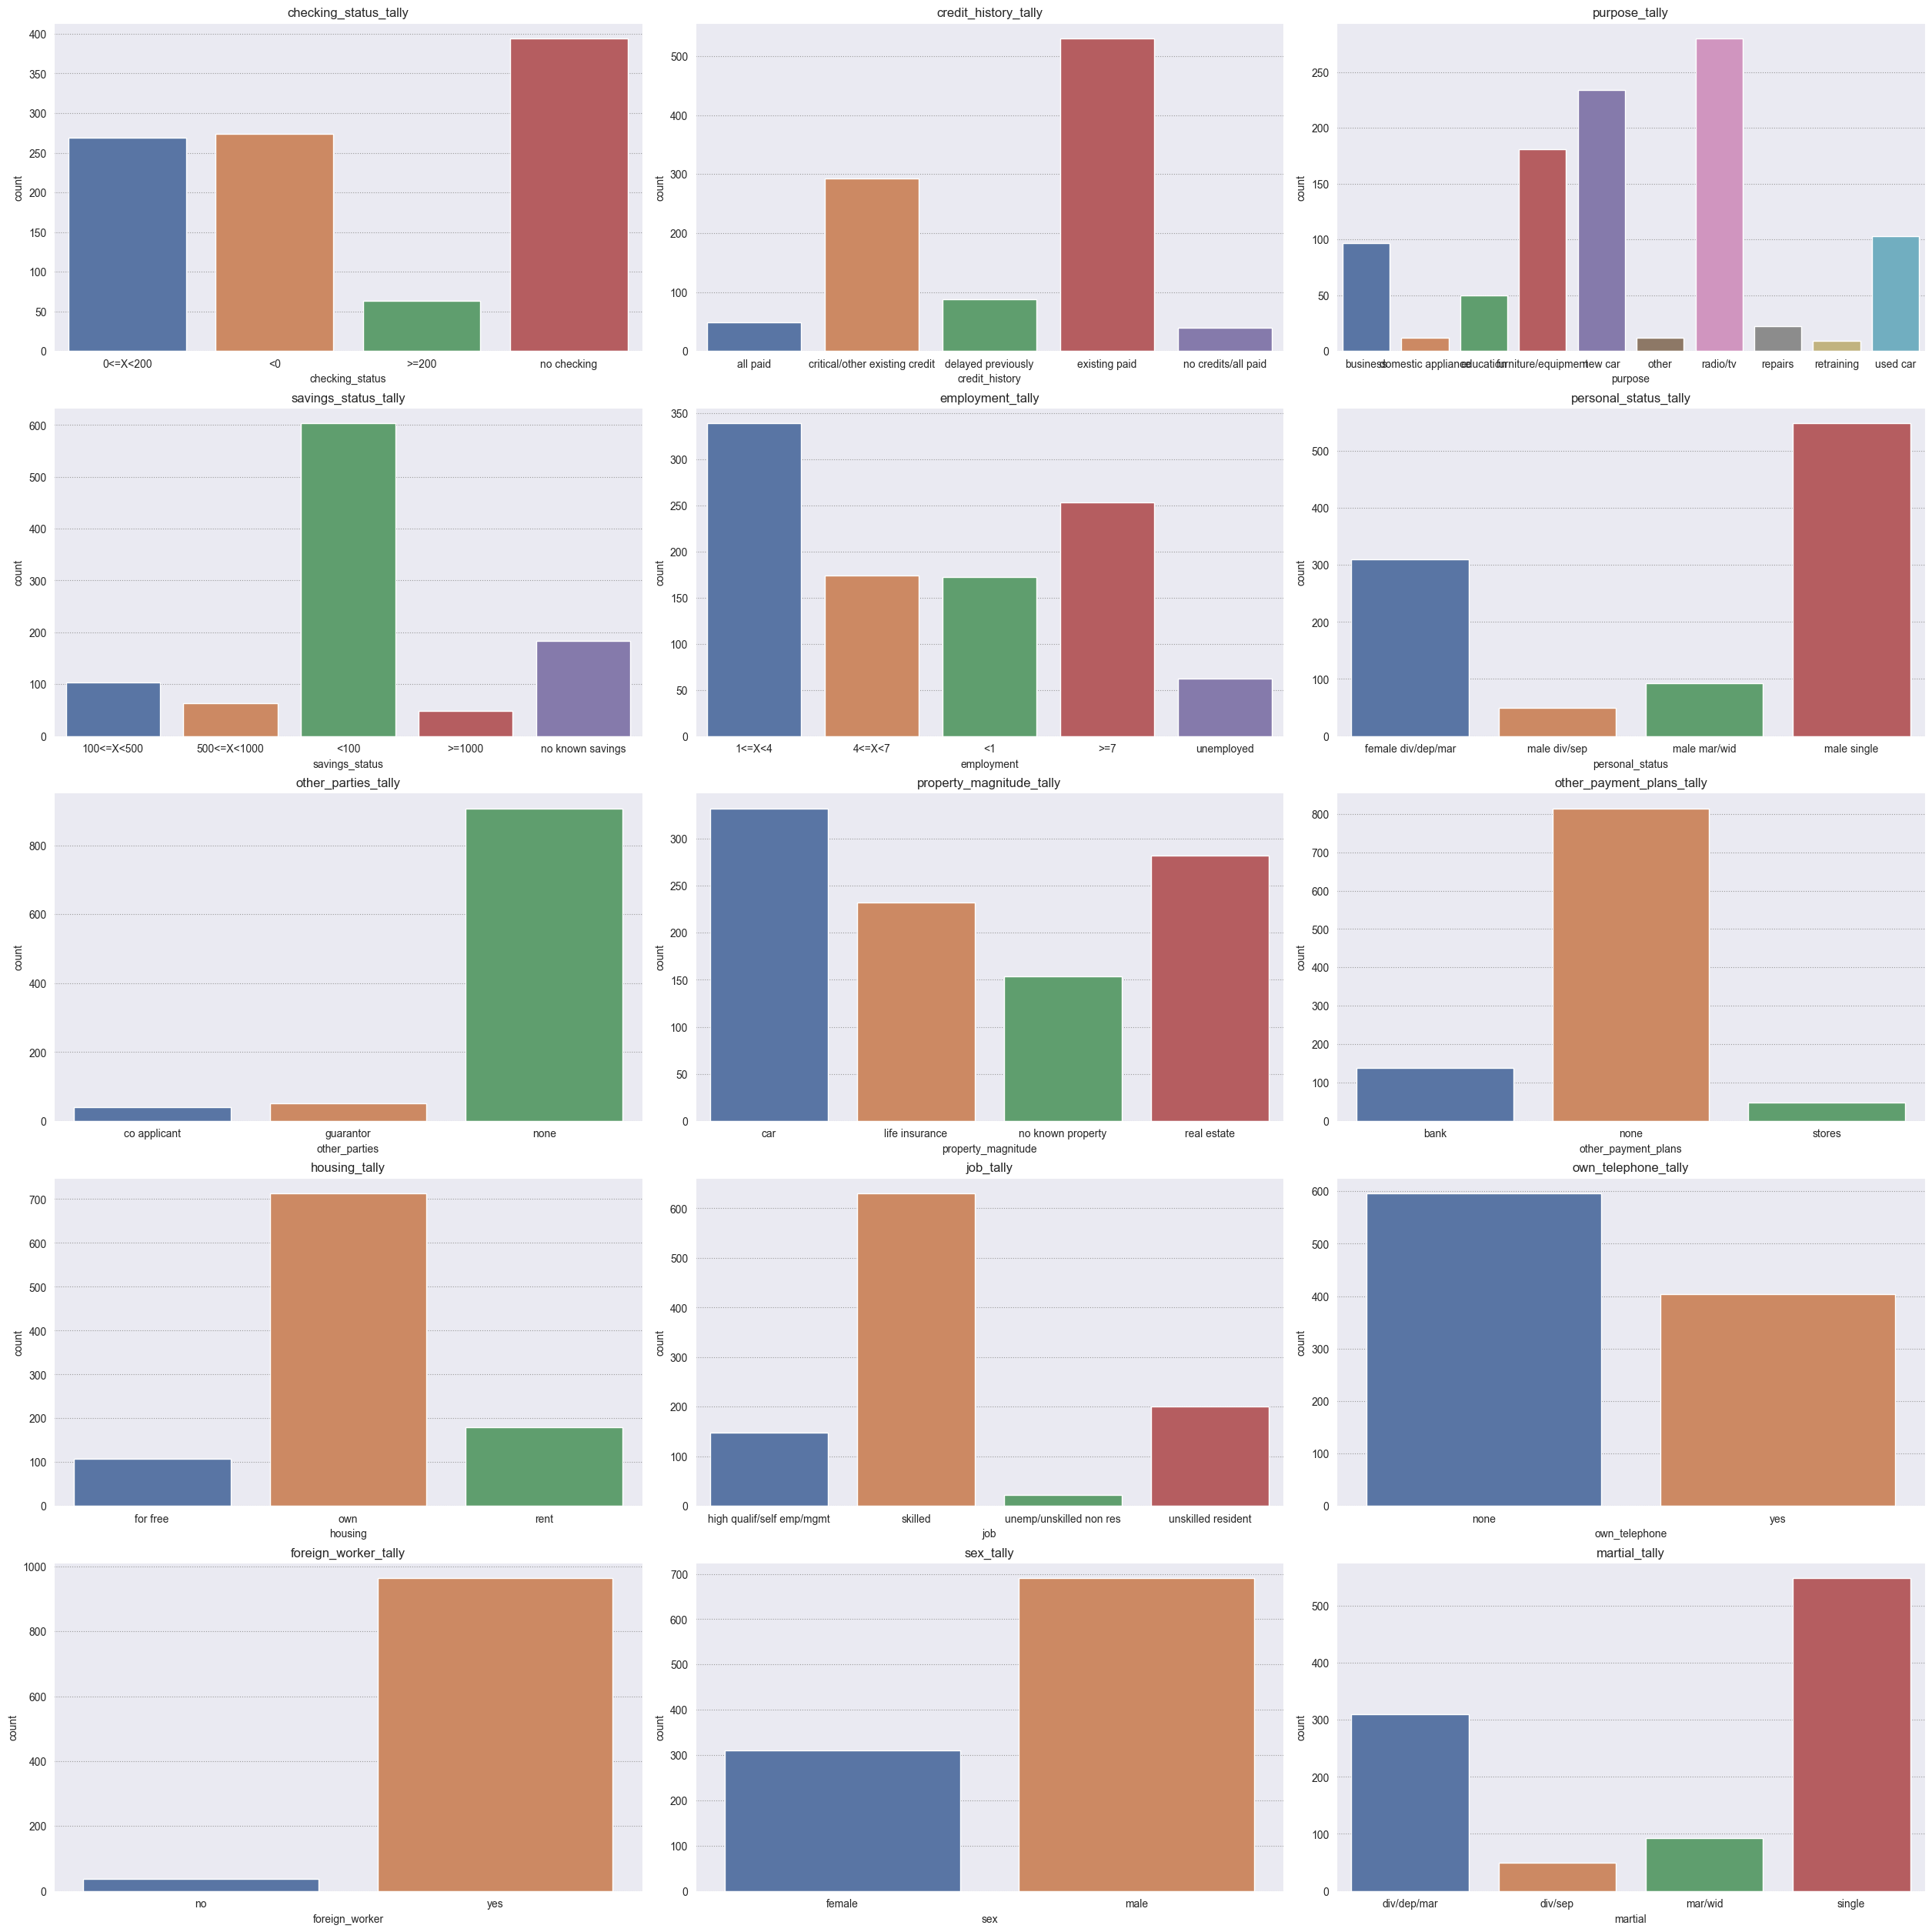

In [9]:
category_cols = DF.select_dtypes('category')

# countplot

plt.figure(**dict(figsize = (25, 25), layout = 'constrained'))

for [i, c] in enumerate(category_cols.columns):
    plt.subplot(5, 3, i+1)
    sns.countplot(
        data = category_cols,
        x = category_cols[c],
        palette = sns.color_palette('deep')
    )
    plt.title(f'{c}_tally')

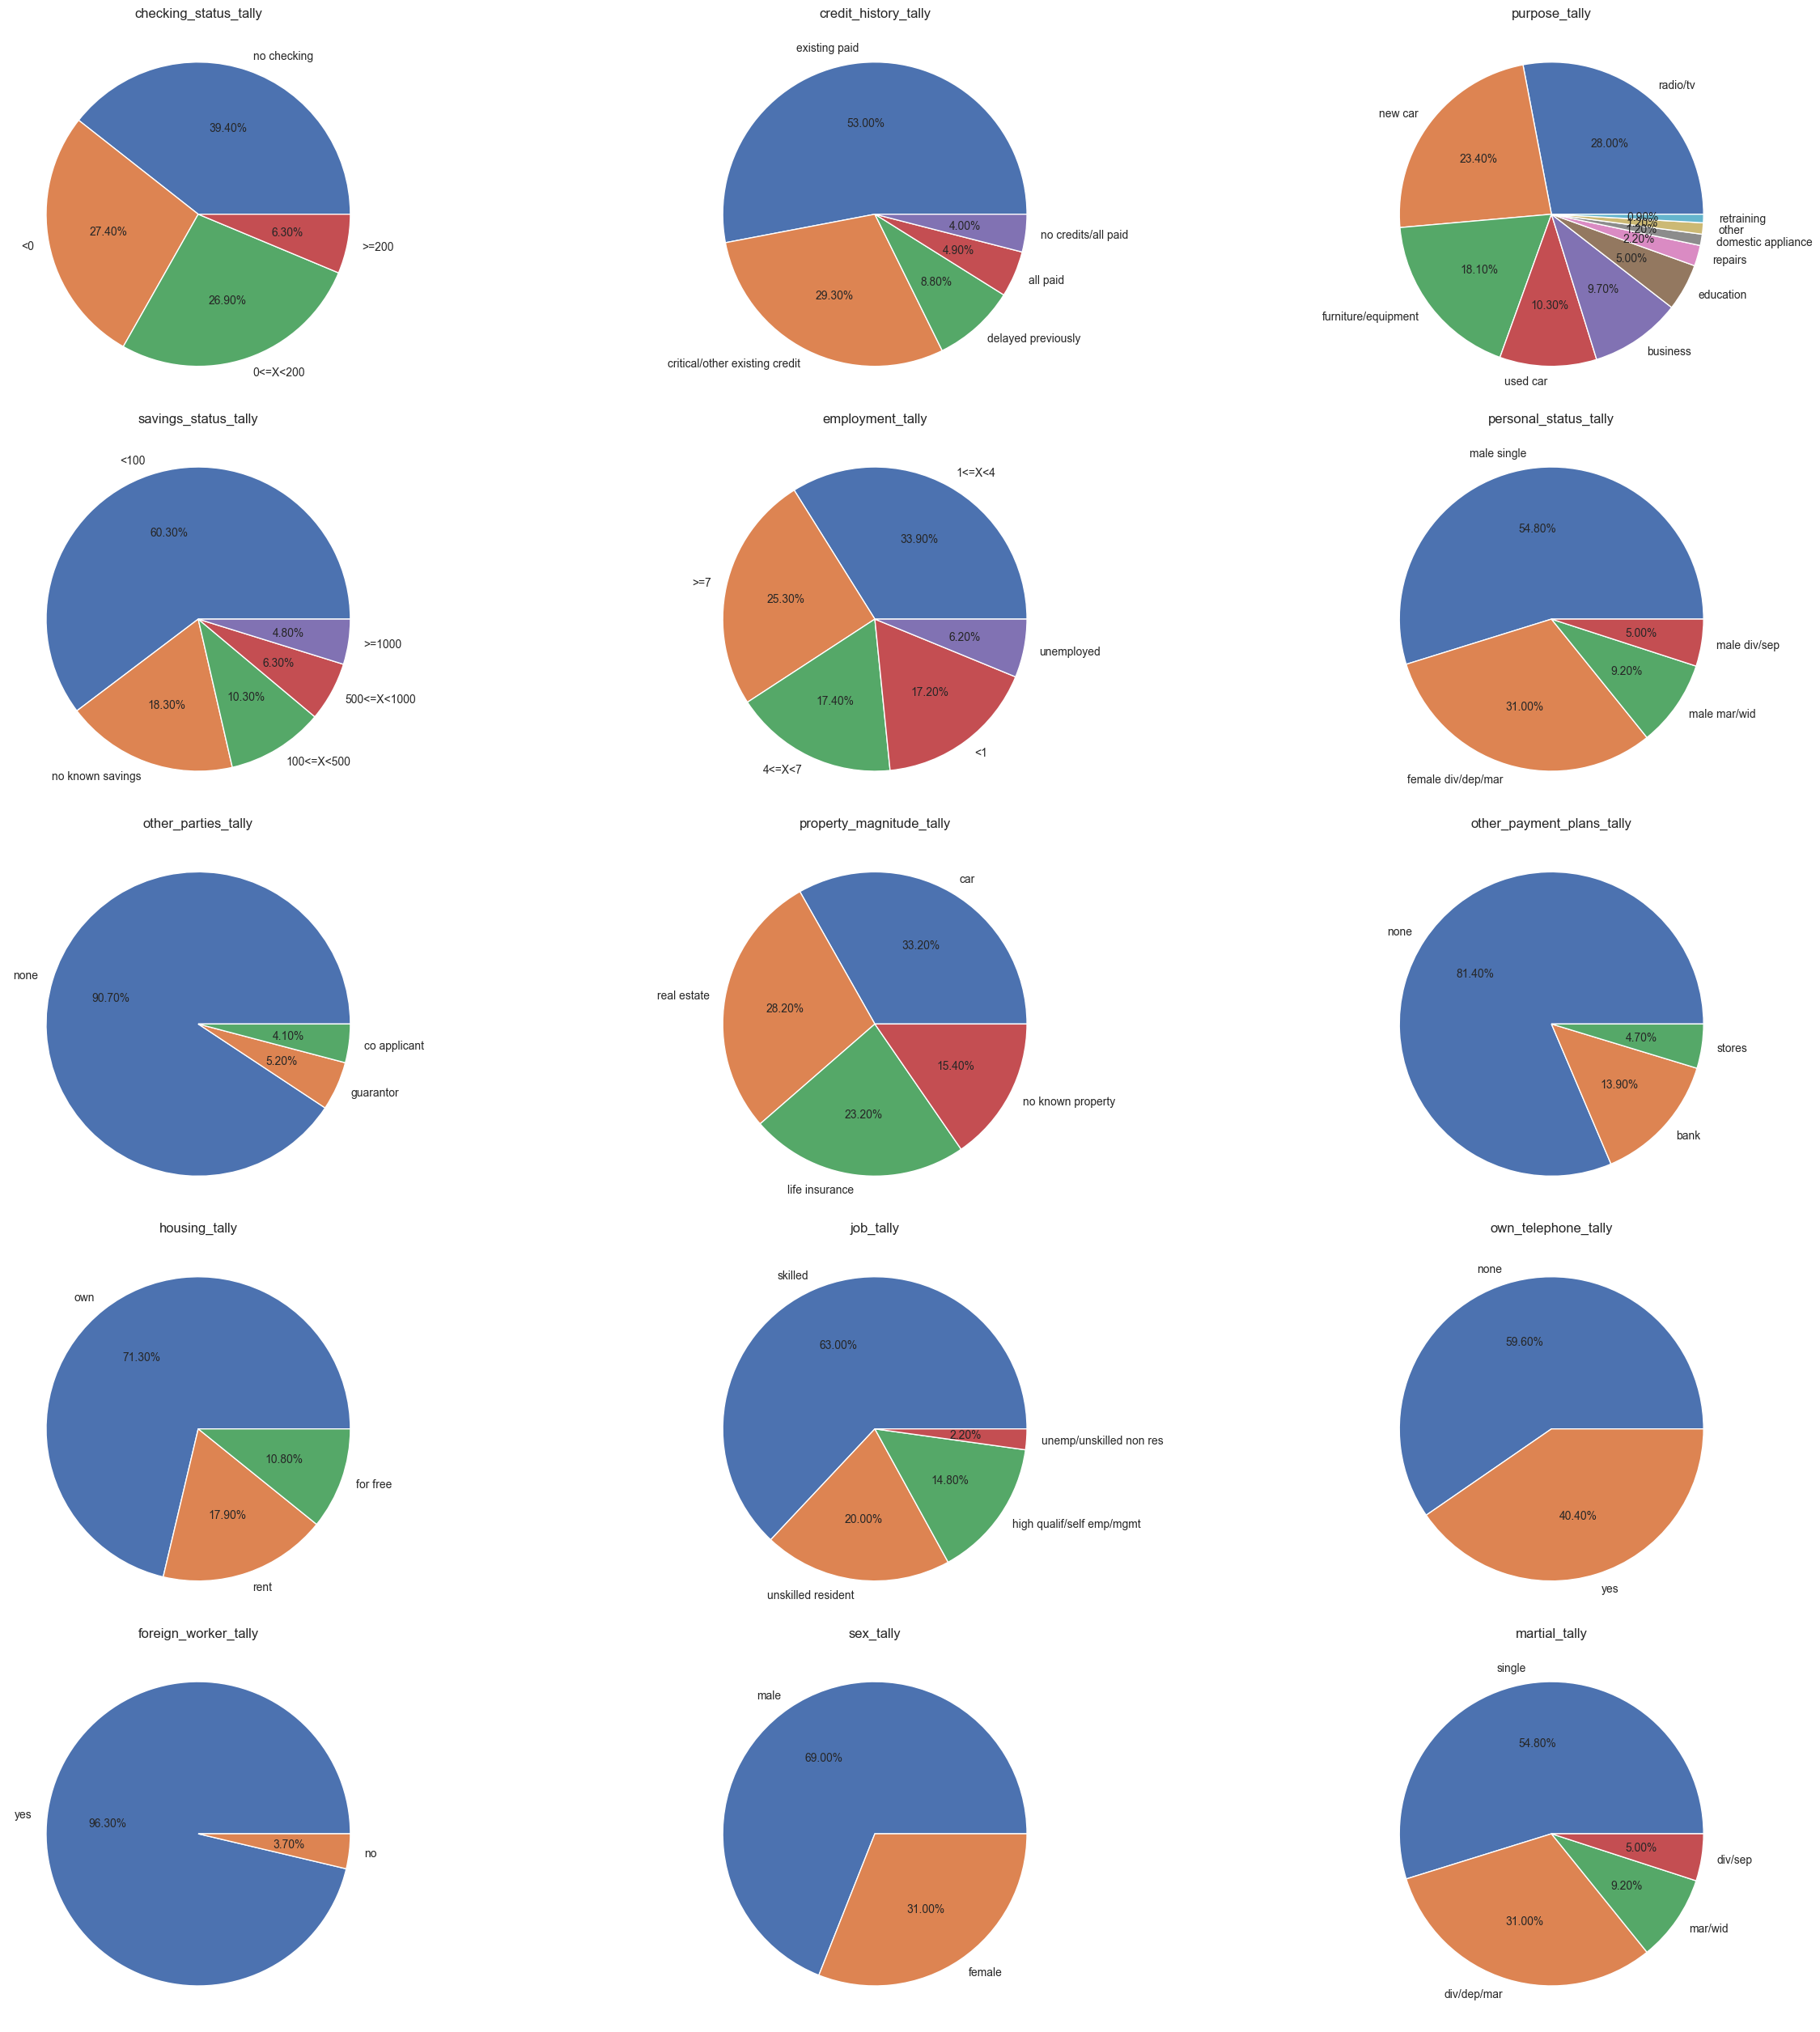

In [10]:
plt.figure(**dict(figsize = (25, 25), layout = 'constrained'))

for [i, c] in enumerate(category_cols.columns):
    plt.subplot(5, 3, i + 1)
    temp = category_cols[c].value_counts()
    label = temp.index
    plt.pie(**dict(x = temp, autopct = '%.2f%%', colors = sns.color_palette('deep'), labels = label))
    plt.title(f'{c}_tally')

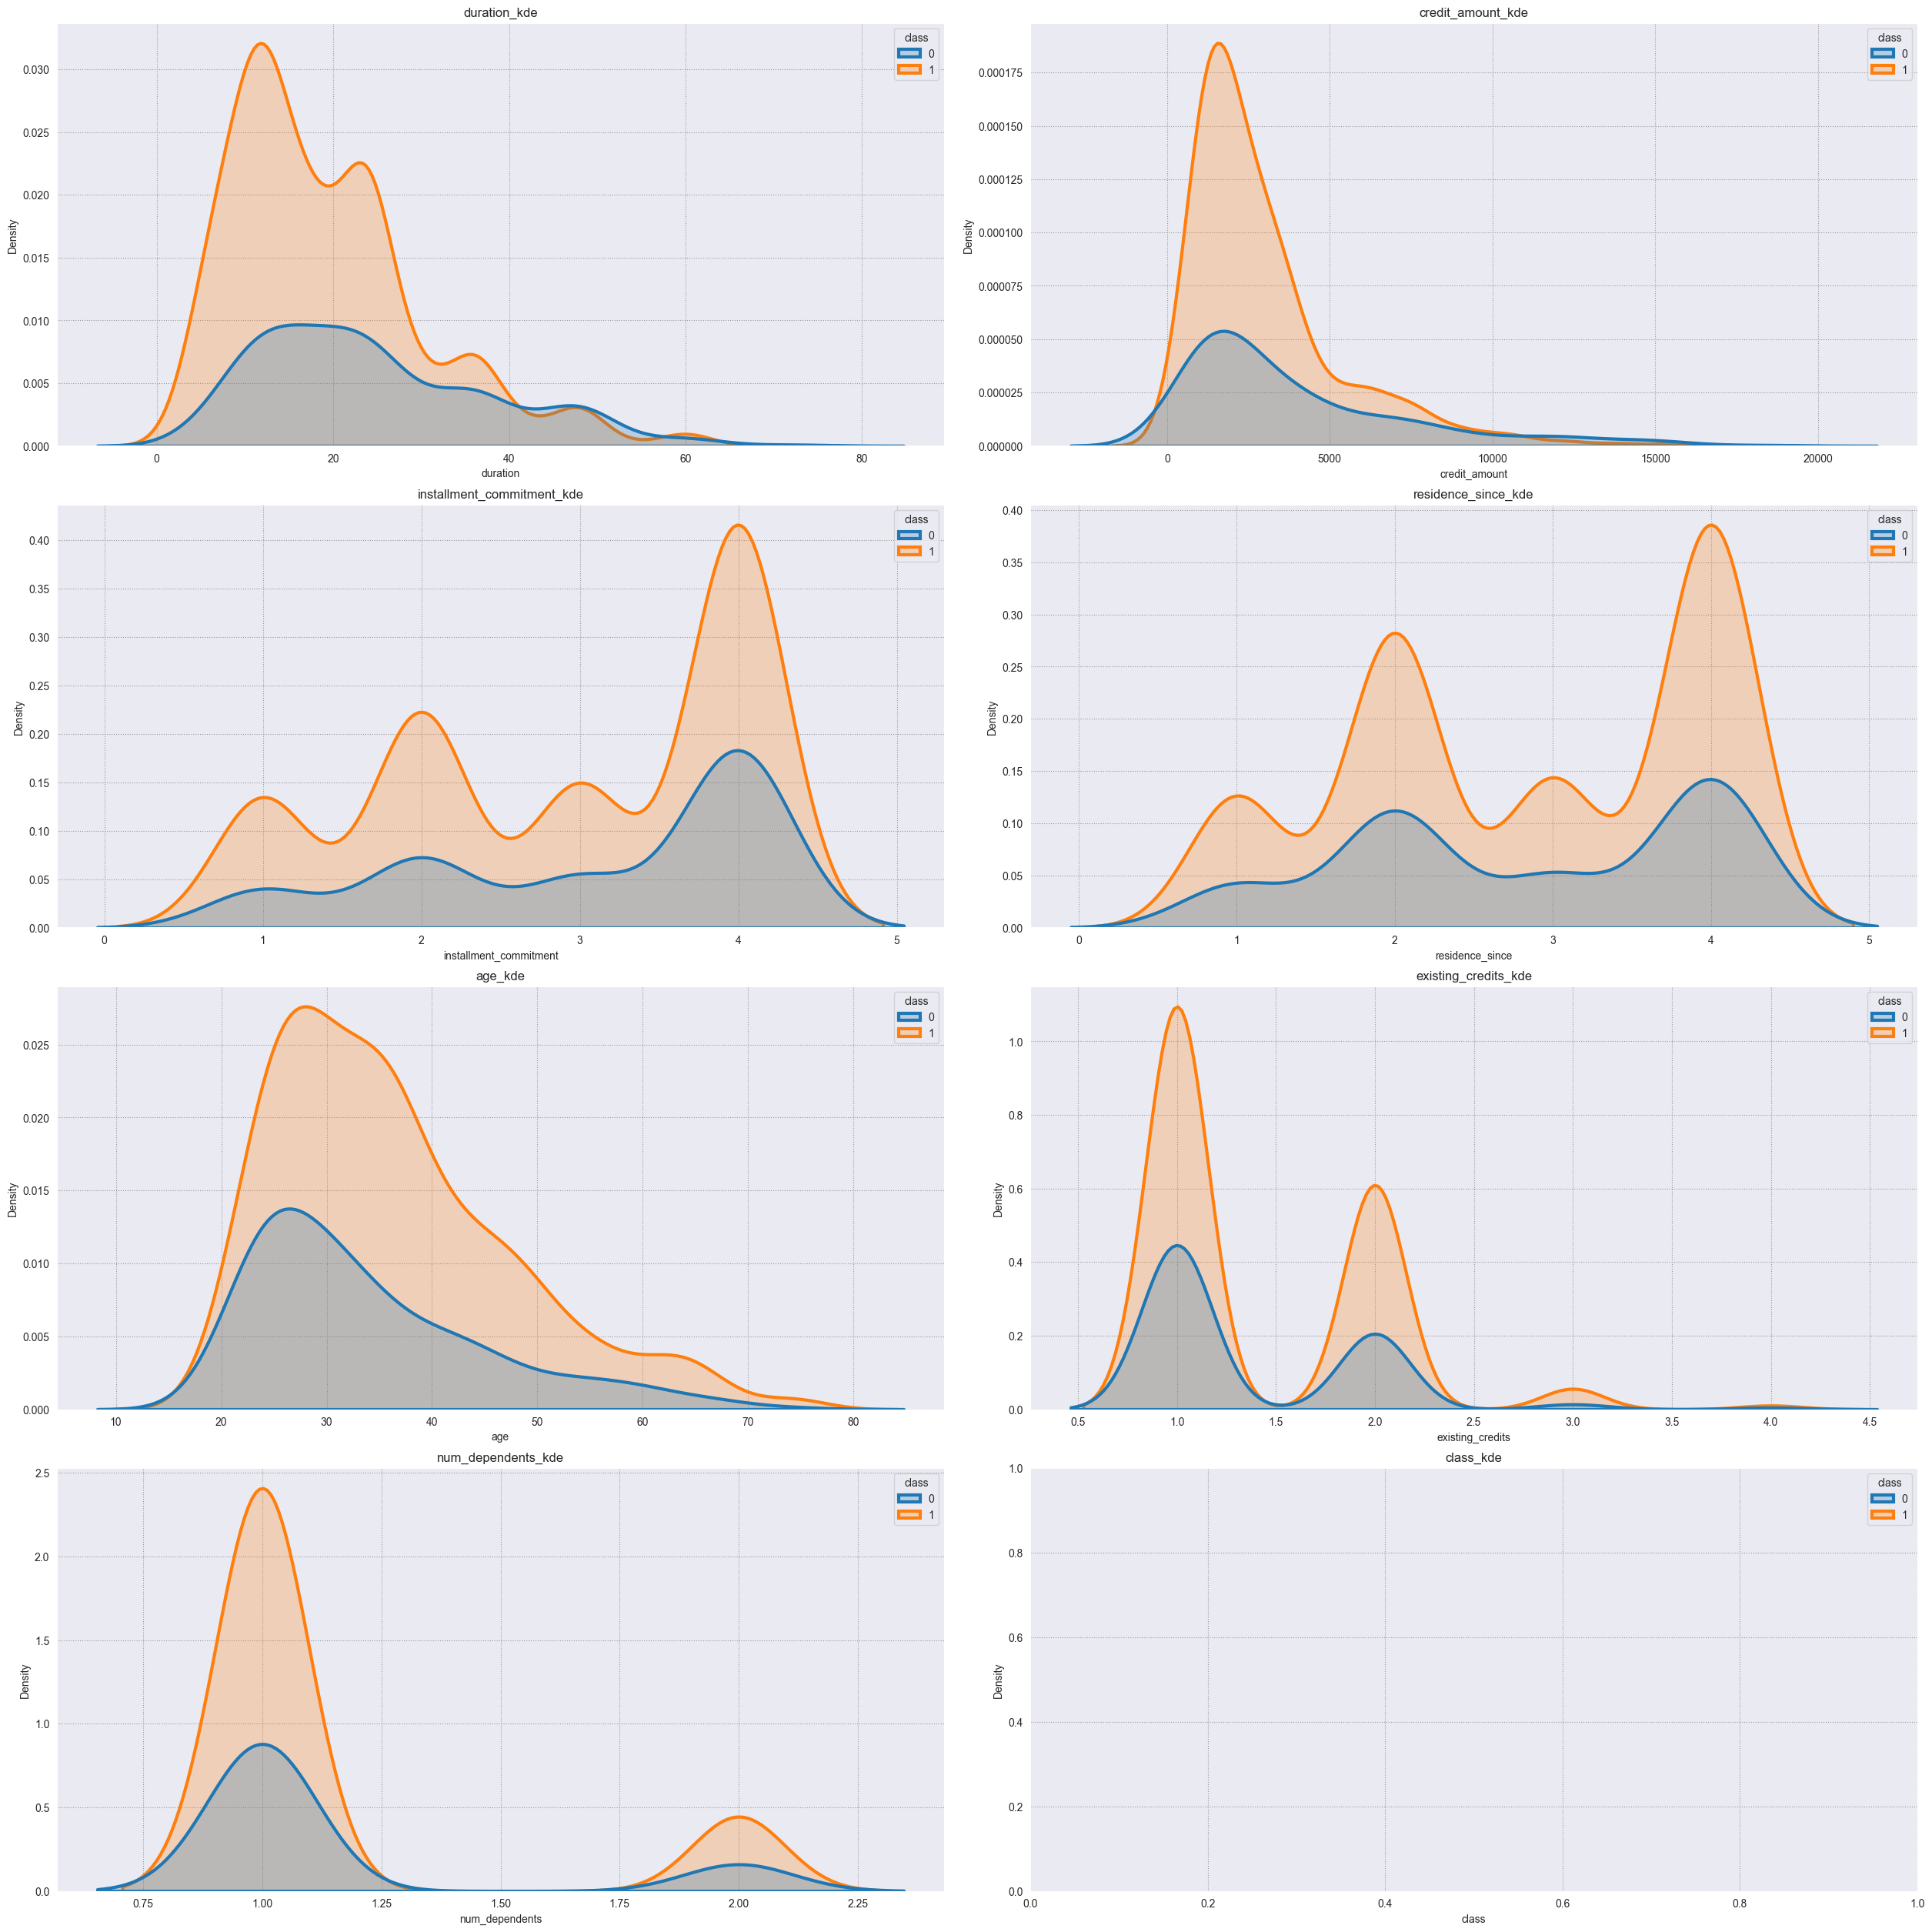

In [11]:
# numerical visualization
numeric_cols = DF.select_dtypes(include=['float64', 'int64'])

plt.figure(**dict(figsize = (25, 25), layout = 'constrained'))

for [i, c] in enumerate(numeric_cols.columns):
    plt.subplot(4, 2, i+1)
    sns.kdeplot(**dict(data = numeric_cols, x=c, hue='class', linewidth = 3, shade= True))
    plt.title(f'{c}_kde')

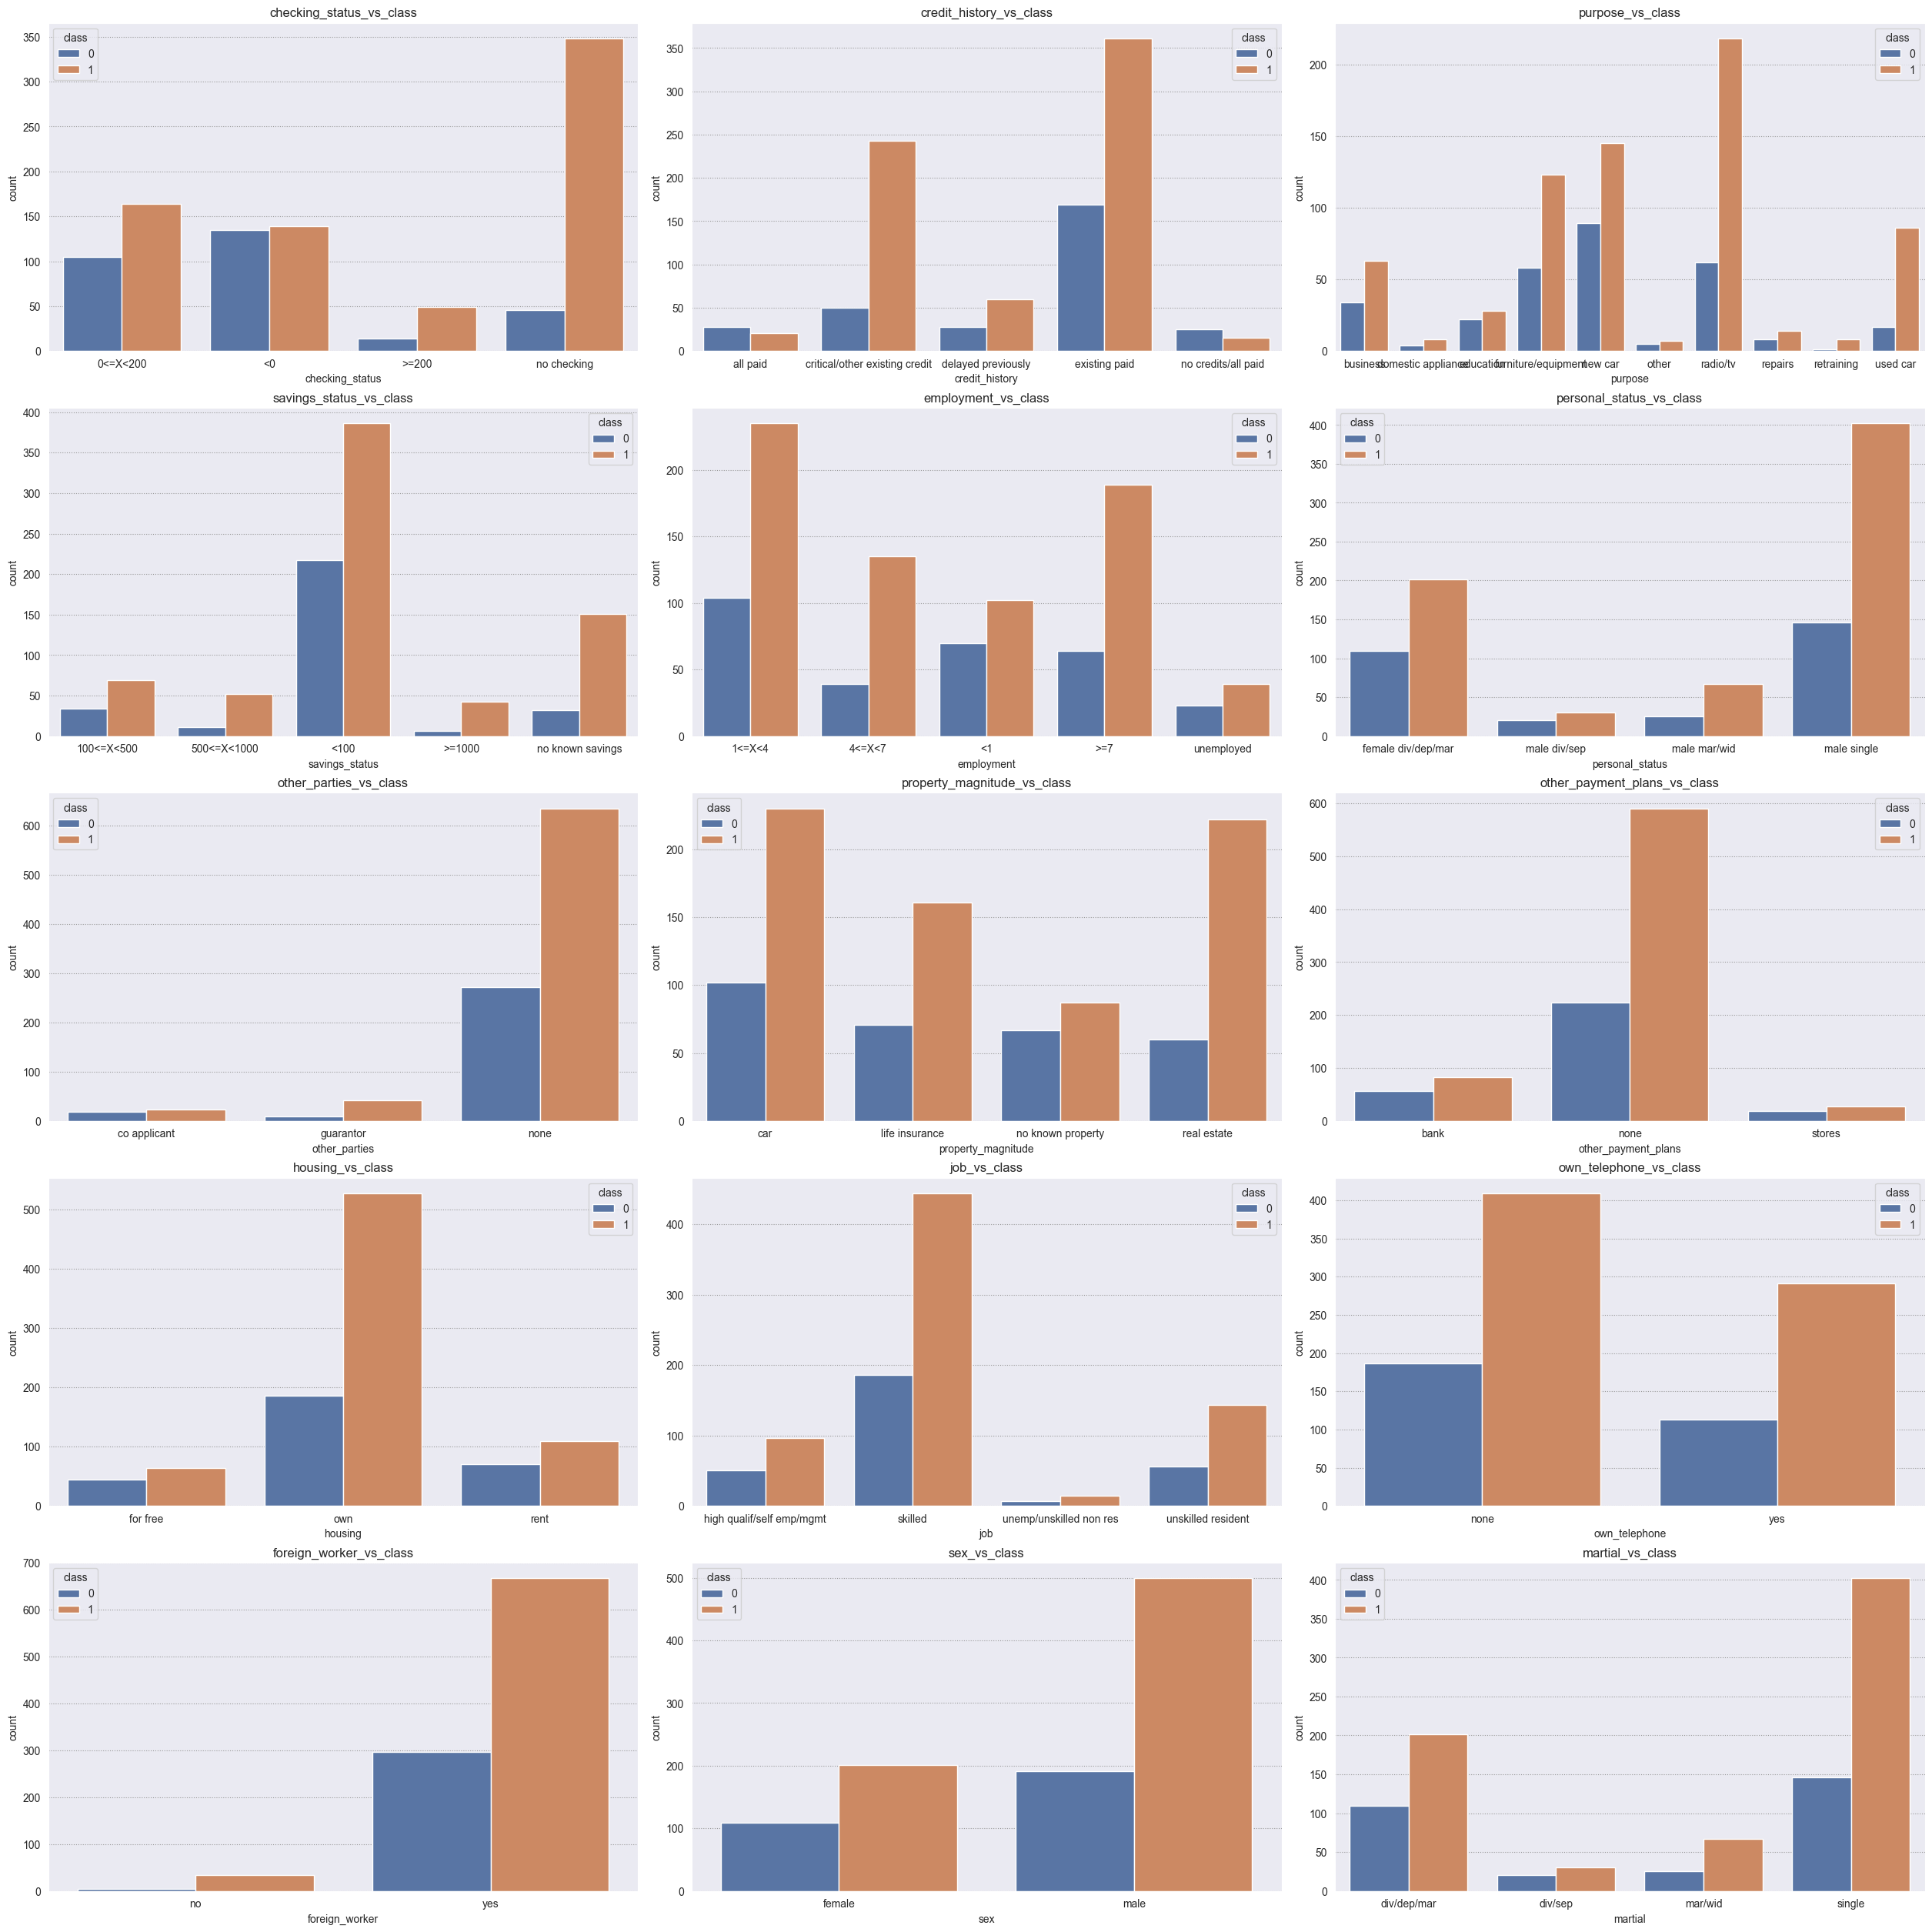

In [12]:
plt.figure(**dict(figsize = (25, 25), layout = 'constrained'))

for [i, c] in enumerate(category_cols.columns):
    plt.subplot(5, 3, i+1)
    sns.countplot(
        data = category_cols,
        x = category_cols[c],
        palette = sns.color_palette('deep'),
        hue = numeric_cols['class']
    )
    plt.title(f'{c}_vs_class')

In [13]:
#IQR

Q1 = numeric_cols.quantile(1/4)
Q3 = numeric_cols.quantile(3/4)

IQR = Q3 - Q1

# trim the dataset via IQR
lower_b = Q1 - IQR*1.5
upper_b = Q3 + IQR*1.5

df = DF[~(
    (DF[numeric_cols.columns] < lower_b) | (DF[numeric_cols.columns] > upper_b)
).any(axis = 1)]

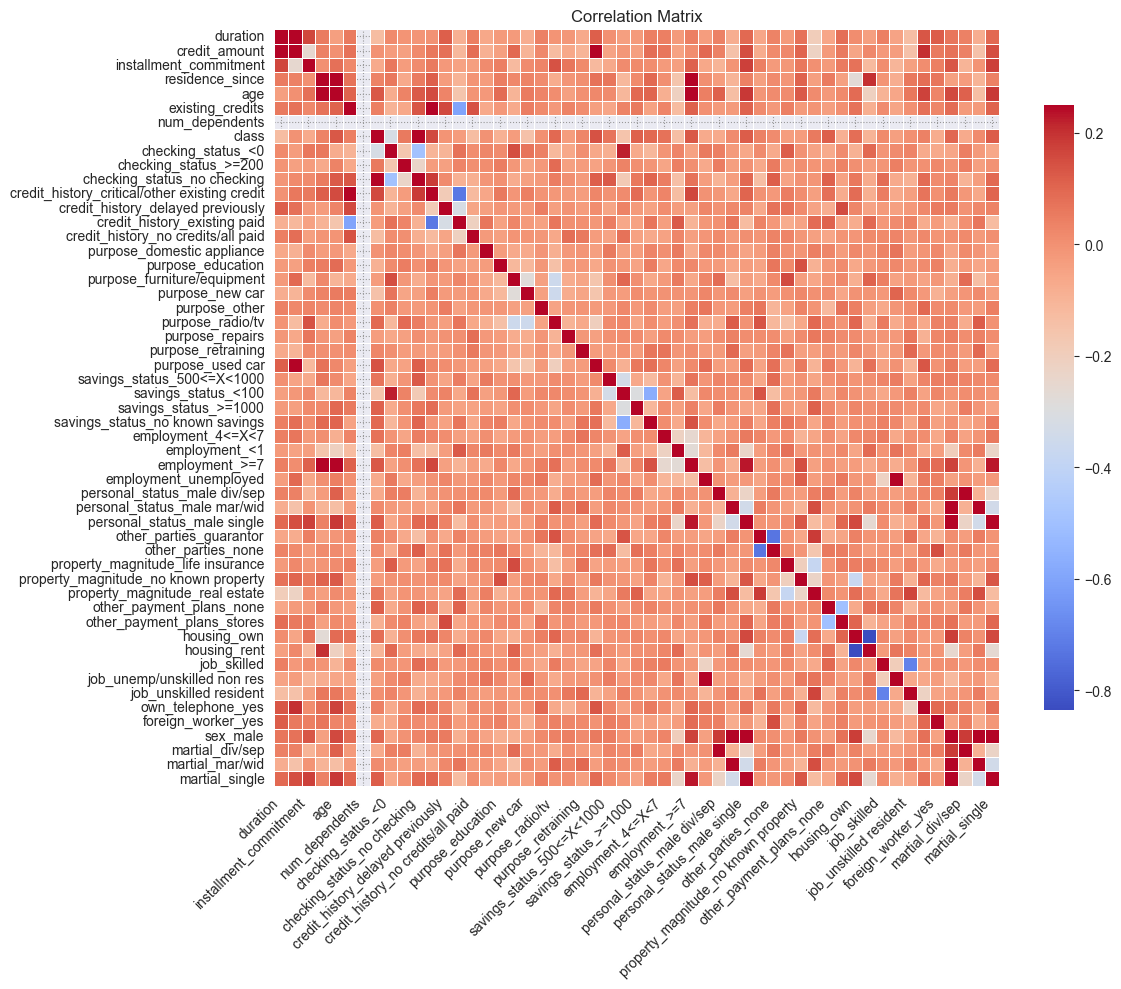

In [16]:
plt.figure(figsize=(12, 10))  # Adjust the figure size for better readability

sns.heatmap(
    corr_matrix,
    annot=False,  # Disable annotations for clearer visualization
    fmt='.2f',
    linewidths=.5,
    cmap='coolwarm',
    vmax=0.25,
    cbar_kws={"shrink": .8},  # Adjust color bar size
)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.title("Correlation Matrix")
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [17]:
del df['num_dependents']

# feature engineering

df['dti'] = df['credit_amount'] / df['installment_commitment']

# age group
bins = [0, 20, 30, 40, 50, 60, 120]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61+']
df['age_agg'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)
del df['age']

# credit utilization
df['credit_util'] = df['credit_amount'] / df['existing_credits']

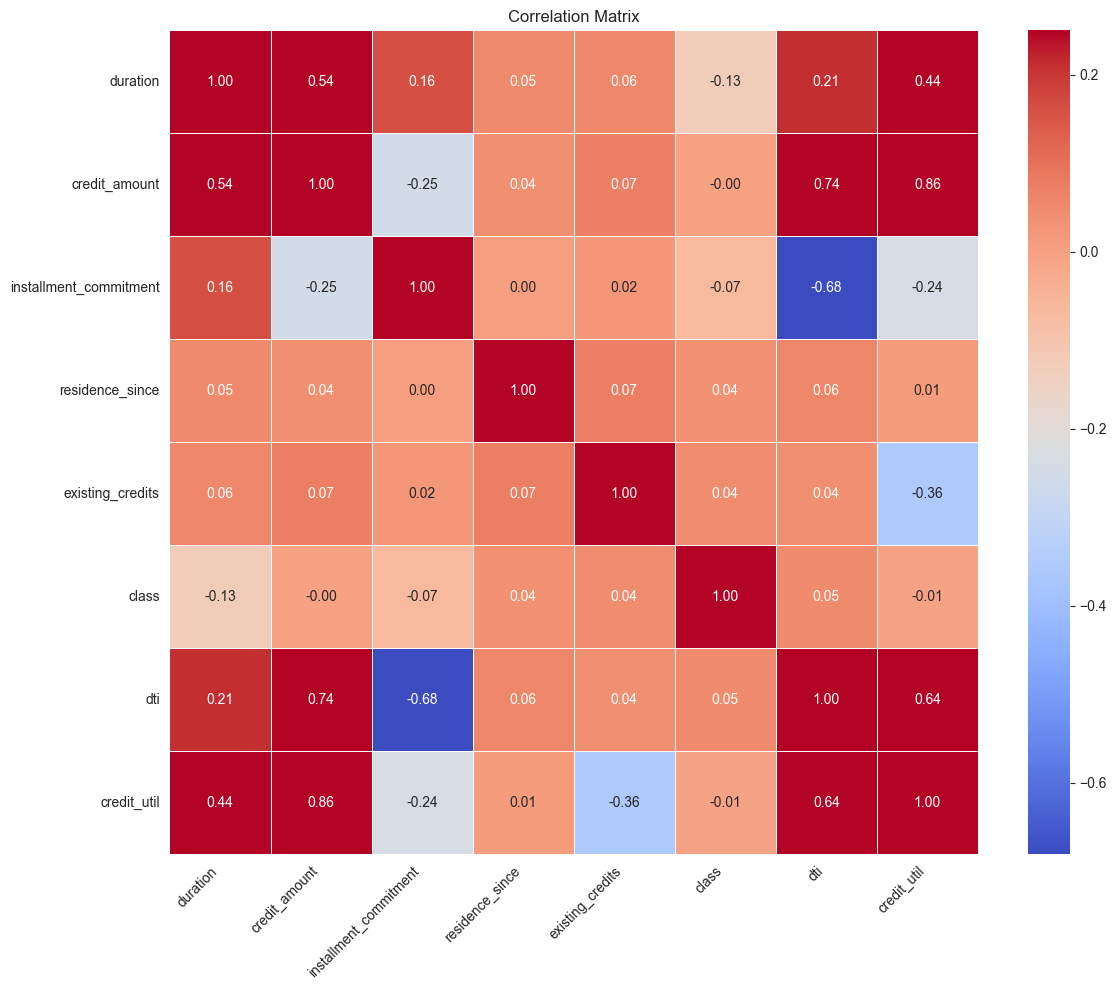

In [19]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='coolwarm',
    vmax=0.25
)
plt.xticks(rotation=45, ha='right')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


# ML Depolyment

In [21]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [22]:
# tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

## XGBoost

In [24]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 1.4 MB/s eta 0:01:29
   ---------------------------------------- 0.8/124.9 MB 1.5 MB/s eta 0:01:22
   ---------------------------------------- 1.3/124.9 MB 1.7 MB/s eta 0:01:12
    --------------------------------------- 1.8/124.9 MB 1.8 MB/s eta 0:01:08
    --------------------------------------- 2.1/124.9 MB 1.8 MB/s eta 0:01:08
    --------------------------------------- 2.6/124.9 MB 1.9 MB/s eta 0:01:04
    --------------------------------------- 2.6/124.9 MB 1.9 MB/s eta 0:01:04
    --------------------------------------- 2.9/124.9 MB 1.6 MB/s eta 0:01:19
   - -------------------------------------- 3.7/124.9 MB 1.7 MB/s eta 0:01:11
   - -------------------------------------- 3.7/124.9 MB 1.7 MB/s eta 0:01:11
   - -------------------------------------- 3.9/124.9 MB 1.6 MB/s eta 0:01:18


In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# normalize input

df_xgb = df.copy(deep = True)
df_xgb[df_xgb.select_dtypes(include=['float64', 'int64']).columns] = MinMaxScaler().fit_transform(df_xgb[df_xgb.select_dtypes(include=['float64', 'int64']).columns])

In [26]:
# one-hot encode for cat cols
for c in df_xgb[df_xgb.select_dtypes('category').columns].columns:
    df_xgb[c] = LabelEncoder().fit_transform(df_xgb[c])

In [27]:
# using SMOTE to compensate for bad debt under representation
y = df_xgb['class']
X = df_xgb.drop('class', axis = 1)

X, y = SMOTE().fit_resample(X, y)

df_xgb = pd.concat([X, y], axis = 1)

In [28]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    df_xgb.drop('class', axis = 1),
    df_xgb['class'],
    test_size = 0.2,
    random_state = 42
)

In [29]:
%%time
# use GridSearchCV to find the best hyperparameters for XGBoost

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000]
}

model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(model, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
CPU times: total: 1.92 s
Wall time: 21.5 s


In [30]:
# Model Deployment
# ? Why does the model has params set to `None` while the Kaggle's nb has vals
model = XGBClassifier(**{**grid_search.best_params_, 'random_state' : 42})
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [37]:
# evaluate

y_pred = model.predict(X_test)
classification_report(y_test, y_pred, output_dict= True)

print('Accuracy: ', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))


Accuracy:  0.8425925925925926
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.85       103
         1.0       0.90      0.79      0.84       113

    accuracy                           0.84       216
   macro avg       0.85      0.85      0.84       216
weighted avg       0.85      0.84      0.84       216



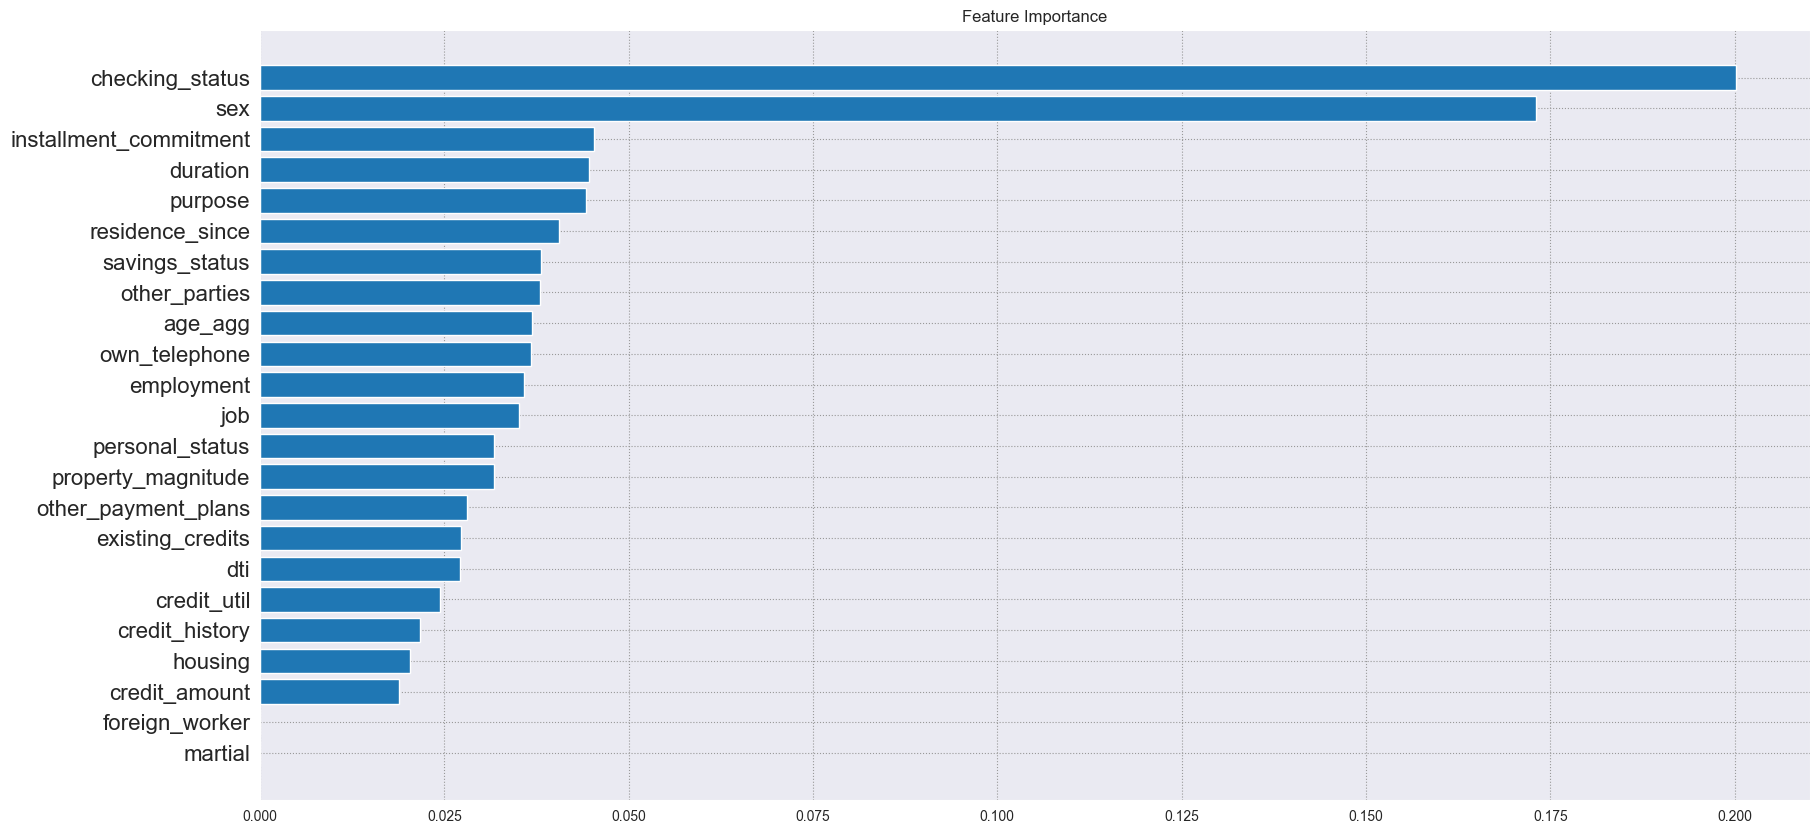

In [39]:
# Create plot
plt.figure(figsize=(20, 10))

# Create plot title
plt.title("Feature Importance")
importance = model.feature_importances_
indices = np.argsort(importance)

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Add bars
plt.barh(range(X_train.shape[1]), importance[indices])

# Add feature names as y-axis labels, rotated vertically
plt.yticks(range(X_train.shape[1]), names, fontsize=16, rotation=0)

# Show plot
plt.show()

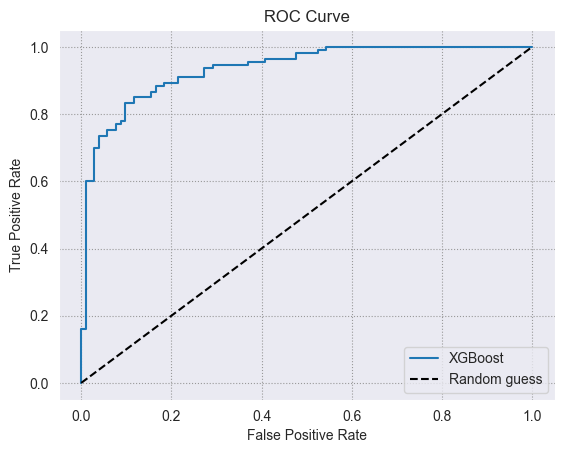

In [40]:
# Plot ROC curve
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [41]:
tpr

array([0.        , 0.00884956, 0.15929204, 0.15929204, 0.60176991,
       0.60176991, 0.69911504, 0.69911504, 0.73451327, 0.73451327,
       0.75221239, 0.75221239, 0.7699115 , 0.7699115 , 0.77876106,
       0.77876106, 0.83185841, 0.83185841, 0.84955752, 0.84955752,
       0.86725664, 0.86725664, 0.88495575, 0.88495575, 0.89380531,
       0.89380531, 0.91150442, 0.91150442, 0.9380531 , 0.9380531 ,
       0.94690265, 0.94690265, 0.95575221, 0.95575221, 0.96460177,
       0.96460177, 0.98230088, 0.98230088, 0.99115044, 0.99115044,
       1.        , 1.        , 1.        , 1.        ])

In [42]:
train_pred = model.predict(X_train)
train_pred_proba = model.predict_proba(X_train)[:,1]
test_pred = model.predict(X_test)
test_pred_proba = model.predict_proba(X_test)[:,1]

train_auc = roc_auc_score(y_train, train_pred_proba)
test_auc = roc_auc_score(y_test, test_pred_proba)

print(f"Train AUC: {train_auc}")
print(f"Test AUC: {test_auc}")

Train AUC: 0.9995564570655848
Test AUC: 0.9354755563192714
